In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

import warnings
import json
from tqdm import tqdm

import os
import gc

from copy import deepcopy

%load_ext tensorboard

warnings.filterwarnings('ignore')

tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tfp.__version__, tf.__version__

('0.16.0', '2.8.0')

# Utils Functions

In [4]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, np.float32):
            return float(obj)
        if isinstance(obj, np.int16):
            return int(obj)
        if isinstance(obj, np.int64):
            return int(obj)
        if isinstance(obj, tf.Tensor):
            return float(obj)
        return json.JSONEncoder.default(self, obj)

In [5]:
def calculate_result(degree, bic_scores, aic_scores, A_list, B_list, losses, best_epochs, lr, optimizer, epochs, batch_size):
    # BIC Results
    best_bic_deg_idx = np.where(bic_scores == np.amin(bic_scores))[0][0]
    best_bic_deg = degrees[best_bic_deg_idx]
    bic_best_A = A_list[best_bic_deg_idx]
    bic_best_B = B_list[best_bic_deg_idx]
    best_bic = bic_scores[best_bic_deg_idx]
    
    # AIC Results
    best_aic_deg_idx = np.where(aic_scores == np.amin(aic_scores))[0][0]
    best_aic_deg = degrees[best_aic_deg_idx]
    aic_best_A = A_list[best_aic_deg_idx]
    aic_best_B = B_list[best_aic_deg_idx]
    best_aic = aic_scores[best_aic_deg_idx]
    
    last_losses = [loss[-1] for loss in losses]
    
    result = {'degree': degree,
          'losses': last_losses,
          'A_list': A_list,
          'B_list': B_list,
              
          'bic_scores': bic_scores,
          'best_bic': best_bic,
          'best_bic_A': bic_best_A,
          'best_bic_B': bic_best_B,
          'best_bic_deg': best_bic_deg,
          'best_bic_deg_idx': best_bic_deg_idx,
            
          'aic_scores': aic_scores,
          'best_aic': best_aic,
          'best_aic_A': aic_best_A,
          'best_aic_B': aic_best_B,
          'best_aic_deg': best_aic_deg,
          'best_aic_deg_idx': best_aic_deg_idx,
              
          'lr': lr,
          'optimizer': optimizer,
          'epochs': epochs,
          'best_epochs': best_epochs,
          'batch_size': batch_size
        }
    
    return result

In [6]:
def save_result(folder_dir, file_name, result):  
    with open(folder_dir + '/' + file_name + '.json', "w") as write_file:
        json.dump(result, write_file, cls=NumpyEncoder)

In [7]:
def nll(dist, samples):
    """Calculates the negative log-likelihood for a given distribution
    and a data set."""
    ll = dist.log_prob(samples)
    mask_ll = tf.boolean_mask(ll, tf.math.is_finite(ll))
    ll = tf.where(tf.math.is_finite(ll), ll, [-1000])
    if mask_ll.shape[0] / ll.shape[0] < 0.7:
        print('Too much nan in one batch', mask_ll.shape[0], ll.shape[0] )
    return -tf.reduce_mean(ll)

In [8]:
#@tf.function
def get_loss_and_grads(dist, samples):
    with tf.GradientTape() as tape:
        tape.watch(dist.trainable_variables)
        loss = nll(dist, samples)
    grads = tape.gradient(loss, dist.trainable_variables)

    return loss, grads

In [29]:
def fit_distribution(dist, samples, opti, epoch):
    loss, grads = get_loss_and_grads(dist, samples)

    if tf.math.is_finite(loss):
        opti.apply_gradients(zip(grads, dist.trainable_variables))

    return loss

In [10]:
#Expands a vector to a polynomial design matrix: from a constant to the deg-power
def polyBasisScale(x_last, deg):
    #Expands a vector to a polynomial design matrix: from a constant to the deg-power
    return np.diag(np.squeeze((np.column_stack([x_last**deg for deg in range(0, deg+1)]))))

In [11]:
def polynomial_basis_function(x, power):
    return x ** power

In [12]:
def expand(x, bf, bf_args=None):
    if bf_args is None:
        return np.concatenate([np.ones(x.shape), bf(x)], axis=1)
    else:
        return np.array([np.ones(x.shape)] + [bf(x, bf_arg) for bf_arg in bf_args]).T

In [13]:
def plot_losses(losses, degrees, y_lim = (-50,50)):
    fig, ax = plt.subplots()
    for i,loss in enumerate(losses):
        ax.plot(range(len(loss)), loss, label = str(degrees[i]))
    
    ax.set_ylim(y_lim)
    ax.legend()

    plt.show()
    return fig, ax

In [14]:
def generate_file_list_dataset(path_list, idx_trajs_select):
    path_list_select = []

    for root, dirs, files in os.walk(os.path.abspath(path_list)):
        files.sort()
    
    files = np.array(files)
    path_list_select_array = files[idx_trajs_select]
    
    for idx, file in enumerate(tqdm(path_list_select_array)):
        path_list_select.append(os.path.join(root, path_list_select_array[idx]))

    file_list_dataset = tf.data.Dataset.from_tensor_slices(path_list_select)
    
    return file_list_dataset

In [15]:
def generate_start_indicies_dataset(start_indicies_file):
    with open(start_indicies_file, "r") as read_file:
        start_indicies_all = np.array((json.load(read_file)))

    start_indicies_dataset = tf.data.Dataset.from_tensor_slices(start_indicies_all)
    
    return start_indicies_dataset

# Load Data

In [17]:
class DataProcessor(object):
    def __init__(self, batch_size, dataset, num_points_in_one_traj):
        self.batch_size = batch_size
        self.dataset = dataset  
        self.num_points_in_one_traj = num_points_in_one_traj
        self.loaded_dataset = None
    
    def _extract_ego_trajs(self, file_path, start_idx):
        file_str = str(file_path.numpy())[2:-1]
        ego_trajs_all = []
        times_all = []
        with open(file_str, "r") as read_file:
            traj_data = json.load(read_file)
            
        ego_traj_temp = np.array(traj_data['ego_traj'])[start_idx : start_idx+self.num_points_in_one_traj]
        agt_traj_temp = np.array(traj_data['agt_trajs'])[start_idx : start_idx+self.num_points_in_one_traj]
        
        d = agt_traj_temp[:, [0,1]] - ego_traj_temp[:, [0,1]] 
        
        c_map_to_ego, s_map_to_ego = np.cos(-ego_traj_temp[:, 3]), -np.sin(ego_traj_temp[:, 3])
        R_map_to_ego = np.transpose(np.array(((c_map_to_ego, -s_map_to_ego), (s_map_to_ego, c_map_to_ego))), (2, 0, 1))

        c_ego_to_map, s_ego_to_map = np.cos(ego_traj_temp[:, 3]), np.sin(ego_traj_temp[:, 3])
        R_ego_to_map = np.transpose(np.array(((c_ego_to_map, -s_ego_to_map), (s_ego_to_map, c_ego_to_map))), (2, 0, 1))
        
        d_rotated = np.abs(np.squeeze(R_map_to_ego  @ d[:, :, None]))
        
        agt_traj_temp = agt_traj_temp[:, :2] - agt_traj_temp[0,:2] # let agt trajectories start from zero
        agt_traj = np.concatenate((agt_traj_temp[:, 0], agt_traj_temp[:, 1]), axis = 0)
        
        times = np.array(traj_data['timestamp'])[start_idx: start_idx+self.num_points_in_one_traj]
        times = times - times[0]
        
        times = tf.convert_to_tensor(times, dtype=tf.float32)
        agt_traj = tf.convert_to_tensor(agt_traj, dtype=tf.float32)
        d_rotated = tf.convert_to_tensor(d_rotated, dtype=tf.float32)
        R_ego_to_map = tf.convert_to_tensor(R_ego_to_map, dtype=tf.float32)
        
        return times, agt_traj, d_rotated, R_ego_to_map
    
    
    def _load_data(self, file_path, start_idx):
        return tf.py_function(self._extract_ego_trajs, [file_path, start_idx], [tf.float32, tf.float32, tf.float32, tf.float32])
    
    def load_process(self, shuffle = False):
        self.loaded_dataset = self.dataset.map(map_func = self._load_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        self.loaded_dataset = self.loaded_dataset.cache()

        # Shuffle data and create batches
        if shuffle:
            self.loaded_dataset = self.loaded_dataset.shuffle(buffer_size=self.loaded_dataset.__len__())
        
        # Set batch size for dataset
        self.loaded_dataset = self.loaded_dataset.batch(self.batch_size)

        # Make dataset fetch batches in the background during the training of the model.
        self.loaded_dataset = self.loaded_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        
    def get_batch(self):
        return next(iter(self.loaded_dataset))

In [43]:
BATCH_SIZE = 1024
EPOCHS = 50
lr = 5e-3

original_num_points_in_one_traj = 91
num_points_in_one_traj = 51

In [39]:
with open("data/agt_trajs_" + str(num_points_in_one_traj) + "_json/agt_trajs_select_non_outlier_indicies.json", "r") as read_file:
    idx_trajs_select = json.load(read_file)
    
#list_dataset = tf.data.Dataset.list_files(str('data/ego_trajs_json/*'), shuffle=False)
list_dataset = generate_file_list_dataset('data/agt_trajs_json/', idx_trajs_select)
start_idx_dataset = generate_start_indicies_dataset("data/agt_trajs_" + str(num_points_in_one_traj) + "_json/agt_trajs_start_point_indicies.json")
combined_dataset = tf.data.Dataset.zip((list_dataset, start_idx_dataset))

dataProcessor = DataProcessor(BATCH_SIZE, combined_dataset, num_points_in_one_traj)
dataProcessor.load_process(shuffle = True)

print(dataProcessor.loaded_dataset.__len__())

100%|██████████| 300000/300000 [00:00<00:00, 556300.05it/s]


tf.Tensor(293, shape=(), dtype=int64)


In [20]:
for times, agt_traj, d_rotated, R_ego_to_map in dataProcessor.loaded_dataset:
    print(times.shape, agt_traj.shape, d_rotated.shape, R_ego_to_map.shape)
    
    phi_t_batch = expand(((times)/t_scale_factor), bf=polynomial_basis_function, bf_args=range(1, deg+1)).transpose((1, 0, 2))
    phi_t_kron = np.kron(np.eye(2), phi_t_batch[:, :, 1:])

    phi_d_lon = expand(d_rotated[:, :, 0], bf=polynomial_basis_function, bf_args=range(1, 2+1)).transpose((1, 0, 2))
    phi_d_lat = expand(d_rotated[:, :, 1], bf=polynomial_basis_function, bf_args=range(1, 2+1)).transpose((1, 0, 2))

    R_samples = np.transpose(R_ego_to_map, (0, 2, 3, 1))

    R = np.block([[tf.linalg.diag(R_samples[:, 0, 0]), tf.linalg.diag(R_samples[:, 0, 1])],
                  [tf.linalg.diag(R_samples[:, 1, 0]), tf.linalg.diag(R_samples[:, 1, 1])]])

    mvn_test = build_mvn(alpha=best_alpha, beta_lon=best_beta_lon, beta_lat=best_beta_lat, phi_t=phi_t_kron, 
                         phi_d_lon=phi_d_lon, phi_d_lat=phi_d_lat, R=R, num_points=num_points_in_one_traj)
    
    ll = mvn_test.log_prob(agt_traj)
    print(d_rotated[3])
    break

(1024, 51) (1024, 102) (1024, 51, 2) (1024, 51, 2, 2)


NameError: name 't_scale_factor' is not defined

# Training

In [40]:
def build_mvn(alpha, beta_lon, beta_lat, phi_t, phi_d_lon, phi_d_lat, R, num_points):
    def mvn_from_alpha_beta(alpha, beta_lon, beta_lat, phi_t, phi_d_lon, phi_d_lat, R):      
        b_lon = tf.squeeze(phi_d_lon @ tf.math.softplus(beta_lon))
        b_lat = tf.squeeze(phi_d_lat @ tf.math.softplus(beta_lat))

        b_diag = tf.linalg.diag(tf.concat([b_lon, b_lat], axis = 1))
        cov = R @ b_diag @ tf.transpose(R, perm=[0, 2, 1]) + (phi_t @ alpha )  @ (tf.transpose(phi_t @ alpha, perm=[0, 2, 1]))

        return tfd.MultivariateNormalTriL(loc=tf.zeros((2*num_points), dtype = tf.float64), scale_tril = tf.linalg.cholesky(cov))
        #return tfd.MultivariateNormalFullCovariance(loc=tf.zeros((2* num_points), dtype = tf.float64), covariance_matrix=cov)
    
    return tfp.experimental.util.DeferredModule(build_fn=mvn_from_alpha_beta, alpha=alpha, beta_lon=beta_lon, beta_lat=beta_lat, 
                                                phi_t = phi_t, phi_d_lon=phi_d_lon, phi_d_lat=phi_d_lat, R=R)

In [41]:
def compute_AIC_BIC(nll, deg, num_points):
    # Compute bayesian information criterion
    degree_of_freedom = 6 + (2*deg)*(2*(deg)+1) / 2
    bic_score = nll + 0.5 * np.log(num_points) * degree_of_freedom
    
    # Compute Akaike information criterion
    aic_score = nll + degree_of_freedom
    
    return aic_score, bic_score

In [42]:
def train(alpha, beta_lon, beta_lat, opti, data_loader, epochs = 100, model_losses = [], tf_summary_writer = None, verbose = False, early_stop = True):
    best_alpha = None
    best_beta_lon, best_beta_lat = None, None
    best_epoch_loss = np.inf
    best_epoch = 0
    t_scale_factor = (num_points_in_one_traj-1) / 10 # The time duration of one trajectory
    for epoch in tqdm(range(epochs)):
        batch_losses = []
        for t_samples, agt_traj_samples, d_samples, R_samples in data_loader:
            phi_t_batch = expand(((t_samples)/t_scale_factor), bf=polynomial_basis_function, bf_args=range(1, deg+1)).transpose((1, 0, 2))
            phi_t_kron = np.kron(np.eye(2), phi_t_batch[:, :, 1:])
            
            phi_d_lon = expand(d_samples[:, :, 0], bf=polynomial_basis_function, bf_args=range(1, 2+1)).transpose((1, 0, 2))
            phi_d_lat = expand(d_samples[:, :, 1], bf=polynomial_basis_function, bf_args=range(1, 2+1)).transpose((1, 0, 2))
            
            R_samples = np.transpose(R_samples, (0, 2, 3, 1))
            
            R = np.block([[tf.linalg.diag(R_samples[:, 0, 0]), tf.linalg.diag(R_samples[:, 0, 1])],
                          [tf.linalg.diag(R_samples[:, 1, 0]), tf.linalg.diag(R_samples[:, 1, 1])]])
            
            phi_t_kron = tf.cast(phi_t_kron, dtype = tf.float64)
            phi_d_lon = tf.cast(phi_d_lon, dtype = tf.float64)
            phi_d_lat = tf.cast(phi_d_lat, dtype = tf.float64)
            R = tf.cast(R, dtype = tf.float64)
            
            mvn_test = build_mvn(alpha=alpha, beta_lon=beta_lon, beta_lat=beta_lat, phi_t=phi_t_kron, 
                                 phi_d_lon=phi_d_lon, phi_d_lat=phi_d_lat, R=R, num_points=num_points_in_one_traj)
            
            agt_traj_samples = tf.cast(agt_traj_samples, dtype = tf.float64)
            batch_loss = fit_distribution(mvn_test, agt_traj_samples, optimizer, epoch)
                    
            batch_losses.append(batch_loss)
            
            tf.keras.backend.clear_session() # clear the initiated model in this loop
        gc.collect()
            
        assert not tf.math.is_nan(np.mean(batch_losses))
        
        epoch_loss = np.mean(batch_losses)
        
        if epoch_loss < best_epoch_loss:
            best_epoch_loss = epoch_loss
            best_epoch = epoch
            best_alpha, best_beta_lon, best_beta_lat = deepcopy(alpha), deepcopy(beta_lon), deepcopy(beta_lat)
        
        model_losses.append(epoch_loss)
        
        if tf_summary_writer:
            with tf_summary_writer.as_default():
                tf.summary.scalar('loss', np.mean(batch_losses), step=epoch)
        
        # Early stop if epoch loss doesn't decrease for more then 20 epochs 
        if early_stop and epoch - best_epoch >=1:
            print('Early Stop at ' + str(epoch) + '(' + str(best_epoch) + ')' + ' epoch')
            break
        
        if(epoch %5 == 0 and verbose):
            #A_scale_mat = polyBasisScale(t_scale_factor, deg)
            #A_scale_mat = A_scale_mat[1:, 1:]
            #A_est = np.linalg.inv(np.kron(np.eye(2), A_scale_mat)) @ A.numpy()
            #A_est = A_est @ A_est.T
            print('Epoch ', epoch, ', Loss: ', model_losses[-1])
            #print(tf.math.softplus(beta_lon), tf.math.softplus(beta_lat))
            #print(np.diag(A_est))
            #print('Rank: ', np.linalg.matrix_rank(mvn_test.covariance()))
        
    return best_epoch_loss, best_epoch, best_alpha, best_beta_lon, best_beta_lat

In [ ]:
losses = []
best_losses = []
best_epoch_losses = []
best_epochs = []
bic_scores = []
aic_scores = []
A_list, B_list = [], []
lr_schedules_ser = []
optimizers_ser = []
t_scale_factor = (num_points_in_one_traj-1) / 10 # The time duration of one trajectory
log_root_dir = 'logs/gradient_tape/agt_xy_test' + str(num_points_in_one_traj) + '1_to_4th'
nan_batches = []
degrees = np.linspace(1, 8, 8, dtype=np.int16) # analyse polynomial from degree 1 to 8
degrees = [1,2,3,4]
for i_d, deg in enumerate(degrees):
    print('Trainig deg ',deg)
    model_losses = []
    if deg <= 4:
        boundaries = [dataProcessor.loaded_dataset.__len__().numpy()*40, dataProcessor.loaded_dataset.__len__().numpy()*70]
        values = [0.001, 1e-4, 5e-5]
    else:
        boundaries = [dataProcessor.loaded_dataset.__len__().numpy()*20, dataProcessor.loaded_dataset.__len__().numpy()*70]
        values = [2e-3, 2e-4, 5e-5]
    #boundaries = [dataProcessor.loaded_dataset.__len__().numpy()*40, dataProcessor.loaded_dataset.__len__().numpy()*70]
    
    #values = [0.005, 0.001, 5e-4]
    lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)   
    
    lr_schedules_ser.append(tf.keras.optimizers.schedules.serialize(lr_schedule))
    optimizers_ser.append(tf.keras.optimizers.serialize(optimizer))

    A = tf.Variable(np.random.randn(2*(deg), 2*(deg))* 1e-1, dtype=tf.float64, name='alpha') # Model uncertainty
    B_lon = tf.Variable(np.random.randn(3, 1), dtype=tf.float64, name='beta_lon') 
    B_lat =  tf.Variable(np.random.randn(3, 1), dtype=tf.float64, name='beta_lat')
    
    train_log_dir = log_root_dir + '/deg_' + str(deg)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)  

    best_epoch_loss, best_epoch, best_alpha, best_beta_lon, best_beta_lat = train(alpha=A, beta_lon=B_lon, beta_lat=B_lat, opti=optimizer, 
                                                     epochs = EPOCHS, data_loader=dataProcessor.loaded_dataset, model_losses = model_losses, tf_summary_writer = train_summary_writer, verbose = False, early_stop=False)
            
    # Add loss
    losses.append(model_losses)
    best_epoch_losses.append([best_epoch_loss])
    
    # store the best epoch
    best_epochs.append(best_epoch)
    
    # Compute AIC and BIC
    aic_score, bic_score = compute_AIC_BIC(nll = best_epoch_loss, deg = deg, num_points = num_points_in_one_traj)

    bic_scores.append(bic_score)
    aic_scores.append(aic_score)
    
    # Compute the model uncertainty, A_unscaled = np.linalg.inv(scale_mat) @ A_scaled
    A_scale_mat = polyBasisScale(t_scale_factor, deg)
    A_scale_mat = A_scale_mat[1:, 1:]
    A_est = np.linalg.inv(np.kron(np.eye(2), A_scale_mat)) @ A.numpy()
    A_est = A_est @ A_est.T
    A_list.append(A_est)
    
    # Compute the observation uncertainty, B_cov = tf.eye(num_points_in_one_traj) * tf.math.softplus(B)
    B_est = {'B_lon': (tf.math.softplus(B_lon)).numpy(), 'B_lat': (tf.math.softplus(B_lat)).numpy()}
    B_list.append(B_est)
    print(deg, model_losses[-1], bic_score, aic_score)

Trainig deg  1


100%|██████████| 50/50 [1:13:33<00:00, 88.27s/it]


1 172.25984823285773 189.9530635801172 181.25984823285773
Trainig deg  2


 56%|█████▌    | 28/50 [41:42<32:23, 88.32s/it] 

In [ ]:
result = calculate_result(degrees, bic_scores, aic_scores, A_list, B_list, best_epoch_losses, best_epochs, lr, optimizers_ser, EPOCHS, BATCH_SIZE)

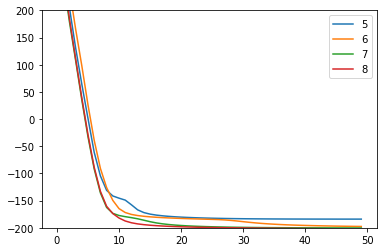

In [49]:
fig,ax = plot_losses(losses, degrees = degrees, y_lim=[-200, 200])
fig.savefig('imgs/agt_' + str(num_points_in_one_traj) + '.svg')

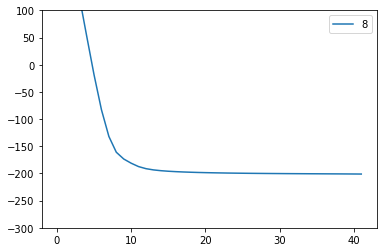

In [36]:
fig,ax = plot_losses([model_losses], degrees = degrees, y_lim=[-300, 100])

In [50]:
result['best_aic_A']

array([[ 3.75269988e+01, -2.22948846e-01, -6.94112738e-02,
         5.14225758e-03,  4.67812436e-05, -1.07983345e+00,
         1.30021188e-01,  1.06832374e-02, -4.31807273e-03,
         3.02459275e-04],
       [-2.22948846e-01,  4.54534579e-01, -1.16268034e-01,
         1.79549466e-02, -1.09575764e-03, -1.59104191e-01,
         8.03627353e-04,  5.80681718e-03, -7.86103081e-04,
         3.35420093e-05],
       [-6.94112738e-02, -1.16268034e-01,  7.83247031e-02,
        -1.63000111e-02,  1.14287612e-03, -7.39092295e-03,
        -3.94375146e-03, -7.19296769e-04,  4.33683842e-04,
        -4.03810775e-05],
       [ 5.14225758e-03,  1.79549466e-02, -1.63000111e-02,
         3.98379946e-03, -3.08399856e-04,  2.23200994e-03,
         2.96028936e-04, -1.02493405e-04, -3.45553125e-05,
         5.53480483e-06],
       [ 4.67812436e-05, -1.09575764e-03,  1.14287612e-03,
        -3.08399856e-04,  2.54747068e-05, -1.04622468e-04,
        -4.99538448e-08,  1.51830878e-05, -4.22469102e-07,
        -1.

In [51]:
result['best_aic_B']

{'B_lon': array([[6.19221377e-04],
        [1.73283434e-06],
        [8.31632567e-07]]),
 'B_lat': array([[1.42990860e-04],
        [2.58744981e-05],
        [5.94708106e-07]])}

In [ ]:
save_result(folder_dir =log_root_dir, file_name='result_summary', result=result)
with open(log_root_dir + '/' + 'lr_schedules' + '.json', "w") as write_file:
    json.dump(lr_schedules_ser, write_file, cls=NumpyEncoder)
with open(log_root_dir + '/' + 'optimizers' + '.json', "w") as write_file:
    json.dump(optimizers_ser, write_file, cls=NumpyEncoder)

Text(0, 0.5, '(m)')

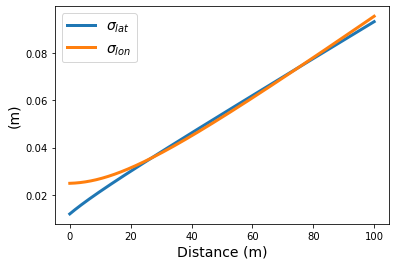

In [52]:
fig, ax = plt.subplots()
d = np.linspace(0, 100, 1000)
sigmas_lat = []
sigmas_lon = []
wd = np.array(result['best_aic_B']['B_lat'])
#wd = tf.math.softplus(best_beta_lat)
for d_i in d:
    sigma = np.sqrt(wd[0] + wd[1]*d_i + wd[2]* (d_i**2))
    sigmas_lat.append(sigma)
ax.plot(d, sigmas_lat, label = '${\sigma}_{lat}$', linewidth = 3)  


wd = np.array(result['best_aic_B']['B_lon'])
#wd = tf.math.softplus(best_beta_lon)
for d_i in d:
    sigma = np.sqrt(wd[0] + wd[1]*d_i + wd[2]* (d_i**2))
    sigmas_lon.append(sigma)
    

ax.plot(d, sigmas_lon, label = '${\sigma}_{lon}$', linewidth = 3) 
ax.legend(fontsize=14)
ax.set_xlabel("Distance (m)", fontsize=14)
ax.set_ylabel("(m)", fontsize=14)